> **Approach**
> --

This model involves applying a series of processing steps on the image before utilising **`Sobel operator`** to obtain the gradient magnitude. These processing steps are **`blurring`** *(gaussian blurring)* and **`contrast enhancement`**. These preprocessing steps help the Sobel edge detector be able to extract the target edges more accurately. Additionally, we *extract the edges for the 3 colour channels independently* before combining them. This is aims to better capture different edges and further increase the accuracy. The edges will be normalised to return the required edge map of edge magnitudes ranging from 0 to 1.

For this entire process, there will be **3 different parameters** to be optimised, namely `blur_amount`, `sigma` and  `contrast_factor`, with the *blurring* step involving involving the first 2 parameters and the *contrast enhancement* step involving the last parameter. Since there are 3 colour channels, there will be 1 sets of 3 parameters each, leading to a total of **9 parameters** for tuning.

Since images differ in terms of their features, they would require unique sets of preprocessing parameters to produce the most optimal accuracy. Hence, we aim to predict the optimal set of preprocessing parameters for each image given their features.

The main idea of this algorithm is to be able to predict the optimal preprocessing parameters based on the features of the image that will best enhance the edge detection. The outline of the algorithm is as follows:  

1.   **Feature Extraction**:
     To begin, we extract 9 different features of the image which would give insights into the appropriate value of parameters to be used in edge detection.  

2.   **Target Generation**:
     For each image, we would also need the target values which are the optimal parameters that preprocesses the images to return the best predictions. This is done using `Bayesian Optimisation`.

3.   **Feature Importance**:
     We use `random forest classifier` to analyse the feature importances and select the top 3 most important features. We then test to check if feature reduction will lead to any improvements in the model's performance

4.   **Parameter Prediction**:
     We use the `random forest classifier` to predict the optimal set of parameters. The hyperparameters of the `random forest classifier` is also tuned using gridsearch to increase the accuracy while reducing overfitting of model.

5.   **Image Preprocessing**:
     The optimal parameters generated are then used to preprocess the images (blurring, contrast enhancement).

6.   **Edge Detection**:
     Lastly, the edges are extracted from the preprocessed image using the `Sobel operator`.

# Imports and Data

Importing essential packages and loading image data  

In [ ]:
!pip install scikit-optimize

In [ ]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from tqdm import tqdm
import time

from PIL import Image, ImageEnhance
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from skimage.measure import shannon_entropy
from skimage.feature import local_binary_pattern
import cv2

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from skopt import gp_minimize
from skopt.space import Categorical

from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# data_dir = #"PATH_TO_YOUR_FOLDER"

# Checking if our specified directory exists
os.path.exists(data_dir)

True

In [ ]:
class BoundaryDataset(object):
    """
    Project boundary dataset wrapper

    Given the path to the root of the dataset, this class provides
    methods for loading images and ground truths.

    Attributes:

    root_dir - the root path of the dataset
    data_path - the path of the data directory within the root
    sample_names - a list of names of images
    """
    def __init__(self, root_dir='.', split='train'):
        """
        Constructor

        :param root_dir: the path to the root of the custom dataset
        :param split: 'train' or 'test'
        """
        self.root_dir = root_dir
        self.data_path = os.path.join(root_dir, split)
        self.sample_names = self._sample_names(self.data_path)

    def __len__(self):
        """
        Get the number of samples in the dataset
        :return: the number of samples
        """
        return len(self.sample_names)

    @staticmethod
    def _sample_names(directory):
        names = []
        files = os.listdir(directory)
        for fn in files:
            name, ext = os.path.splitext(fn)
            if ext.lower() == '.jpg':
                names.append(name)
        return names

    def read_image(self, name):
        """
        Load the image identified by the sample name
        :param name: the sample name
        :return: a (H,W,3) array containing the image
        """
        path = os.path.join(self.data_path, f"{name}.jpg")
        return imread(path)

    def load_boundaries(self, name):
        """
        Load the boundaries identified by the sample name
        :param name: the sample name
        :return: a list of (H,W) arrays, each of which contains a boundary ground truth
        """
        boundary_path = os.path.join(self.data_path, f"{name}.npy")
        if os.path.exists(boundary_path):
            boundaries = np.load(boundary_path, allow_pickle=True)
            return list(boundaries)
        return []

In [ ]:
split = 'train'

# Load the dataset using BoundaryDataset class
train_dataset = BoundaryDataset(data_dir + "/project_data", split=split)

print(f"Data size: {len(train_dataset)}")

Data size: 200


In [ ]:
split = 'test'

# Load the dataset using BoundaryDataset class
test_dataset = BoundaryDataset(data_dir + "/project_data", split=split)

print(f"Data size: {len(test_dataset)}")

Data size: 100


# Defining Functions

In [ ]:
# Defining feature names. These features will be extracted from the image
feature_names = [
    "Edge Density",
    "Edge Sharpness",
    "Color Contrast",
    "RMS Contrast",
    "Entropy",
    "Mean Intensity",
    "Standard Deviation of Intensity",
    "Color Channel Variability",
    "Spatial Frequency"
]

In [ ]:
# Functions to extract features from the images

# 1. Edge Density
def compute_edge_density(image):
    """Compute the density of edges in the edge map."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    edge_density = np.sum(edges > 0) / float(edges.size)
    return edge_density

# 2. Edge Sharpness
def compute_edge_sharpness(image):
    """Compute the sharpness of the edges based on gradient magnitude."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    sharpness = np.mean(gradient_magnitude)
    return sharpness

# 3. Color Contrast (Standard Deviation of Intensity)
def compute_color_contrast(image):
    """Compute the standard deviation of pixel intensities to measure contrast."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray_image)
    return contrast

# 4. Root Mean Square (RMS) Contrast
def compute_rms_contrast(image):
    """Compute the Root Mean Square (RMS) contrast of the image."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray_image)
    rms_contrast = np.std(gray_image) / mean_intensity
    return rms_contrast

# 5. Entropy
def compute_entropy(image):
    """Compute the entropy of the image."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    entropy_value = shannon_entropy(gray_image)
    return entropy_value

# 6. Mean Intensity
def compute_mean_intensity(image):
    """Compute the mean intensity (average pixel value) of the image."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray_image)
    return mean_intensity

# 7. Standard Deviation of Intensity
def compute_std_intensity(image):
    """Compute the standard deviation of pixel intensities in the image."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    std_intensity = np.std(gray_image)
    return std_intensity

# 8. Colour Channel Variability
def compute_color_channel_variability(image):
    """Compute the color channel variability (variance) in a color image."""
    # Split the image into RGB channels
    (B, G, R) = cv2.split(image)

    # Compute the variance for each channel
    variance_R = np.var(R)
    variance_G = np.var(G)
    variance_B = np.var(B)

    # Return the average variance across all three channels
    color_variability = (variance_R + variance_G + variance_B) / 3
    return color_variability

# 9. Spatial Frequency
def compute_spatial_frequency(image):
    """Compute the spatial frequency of the image."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply the Fourier Transform
    f_transform = np.fft.fft2(gray_image)
    f_transform_shifted = np.fft.fftshift(f_transform)  # Shift zero frequency to center

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(f_transform_shifted)

    # Calculate the average frequency (spatial frequency)
    avg_spatial_frequency = np.mean(magnitude_spectrum)

    return avg_spatial_frequency

In [ ]:
# Function to generate edges for each channel (RGB) and combine them
def generate_edges_rgb(image, blur_amounts, sigmas, contrast_factors):
    # Separate the channels
    red_channel = image[:, :, 2]  # Red channel
    green_channel = image[:, :, 1]  # Green channel
    blue_channel = image[:, :, 0]  # Blue channel

    # Process each channel independently
    def process_channel(channel, blur_amount, sigma, contrast_factor):

        blurred = cv2.GaussianBlur(channel, (blur_amount, blur_amount), sigma)

        img_pil = Image.fromarray(blurred)
        enhanced_img_pil = ImageEnhance.Contrast(img_pil).enhance(contrast_factor)
        enhanced_img = np.array(enhanced_img_pil)

        grad_x = cv2.Sobel(enhanced_img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(enhanced_img, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Normalize the gradient magnitude to [0, 1]
        gradient_magnitude_min = np.min(gradient_magnitude)
        gradient_magnitude_max = np.max(gradient_magnitude)
        normalized_gradient = (gradient_magnitude - gradient_magnitude_min) / (gradient_magnitude_max - gradient_magnitude_min)

        return normalized_gradient

    red_edges = process_channel(red_channel, blur_amounts[0], sigmas[0], contrast_factors[0])
    green_edges = process_channel(green_channel, blur_amounts[1], sigmas[1], contrast_factors[1])
    blue_edges = process_channel(blue_channel, blur_amounts[2], sigmas[2], contrast_factors[2])

    # Combine the edges from all channels
    combined_edges = np.maximum.reduce([red_edges, green_edges, blue_edges])

    return combined_edges

In [ ]:
# Function to return the f1 score of the similarity comparison between the predicted edges (generated with the given parameters) and the boundaries
def objective(params, image, boundaries):
    # Extract the parameters for each channel
    blur_params = params[:3]
    sigma_params = params[3:6]
    contrast_params = params[6:]

    print(f"Evaluating: Blur: {blur_params}, Sigma: {sigma_params}, Contrast: {contrast_params}")

    # Generate edges based on the current set of parameters
    edges = generate_edges_rgb(image, blur_params, sigma_params, contrast_params)

    # Calculate F1 scores for each boundary
    f1_scores = [f1_score((boundary > 0).astype(int).flatten(), (edges > 0.5).astype(int).flatten()) for boundary in boundaries]
    max_f1 = np.max(f1_scores)

    # We negate the F1 score because Bayesian Optimization minimizes the objective function
    return -max_f1

In [ ]:
# Function to predict the optimal parameters based on the features of the image
def predict_optimal_parameters(model, image, blur_encoder, sigma_encoder, contrast_encoder, top_features_idx):

    # extrating features
    feature_vector = [
        compute_edge_density(image),
        compute_edge_sharpness(image),
        compute_color_contrast(image),
        compute_rms_contrast(image),
        compute_entropy(image),
        compute_mean_intensity(image),
        compute_std_intensity(image),
        compute_color_channel_variability(image),
        compute_spatial_frequency(image)
    ]

    top_feature_vector = [feature_vector[i] for i in top_features_idx]

    # Predict the optimal parameters
    predicted_params_encoded = model.predict([top_feature_vector])[0]

    # Extracting the parameters
    blur_params_encoded = predicted_params_encoded[:3]
    sigma_params_encoded = predicted_params_encoded[3:6]
    contrast_params_encoded = predicted_params_encoded[6:]

    blur_params = [blur_encoder.inverse_transform([encoded])[0] for encoded in blur_params_encoded]
    sigma_params = [sigma_encoder.inverse_transform([encoded])[0] for encoded in sigma_params_encoded]
    contrast_params = [contrast_encoder.inverse_transform([encoded])[0] for encoded in contrast_params_encoded]

    return blur_params, sigma_params, contrast_params

# 1. Feature Extraction + 2. Target Generation

Here, we define the possible parameter ranges and set up the search space to find the optimal set of parameters that will give the most accurate predicted edges.

The parameters we will be tuning are blur_amount, sigma and contrast_factor. We have 1 set of parameters for each of the 3 colour channels, hence resulting in a total of 9 colour channels.

In [ ]:
# Define possible parameter ranges
blur_amounts = [3, 5, 7, 9]
sigmas = [1.0, 3.0, 5.0, 7.0, 9.0]
contrast_factors = [1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

blur_encoder = LabelEncoder()
sigma_encoder = LabelEncoder()
contrast_encoder = LabelEncoder()

blur_encoder.fit(blur_amounts)
sigma_encoder.fit(sigmas)
contrast_encoder.fit(contrast_factors)

# search space of paramters of blur_amounts, sigmas, contrast_factors
search_space = [
    Categorical([3, 5, 7, 9]), # blur_amount for red
    Categorical([3, 5, 7, 9]), # blur_amount for green
    Categorical([3, 5, 7, 9]), # blur_amount for blue
    Categorical([1.0, 3.0, 5.0, 7.0, 9.0]), # sigma for red
    Categorical([1.0, 3.0, 5.0, 7.0, 9.0]), # sigma for green
    Categorical([1.0, 3.0, 5.0, 7.0, 9.0]), # sigma for blue
    Categorical([1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]), # contrast_factor for red
    Categorical([1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]), # contrast_factor for green
    Categorical([1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])  # contrast_factor for blue
]

We extract the X and y, where X is the features and y is the target.
X and y is used to construct the random forest model.

X represents the features of the image.  
y represnets the target values, which are the 9 parameters.

For each image, we extract the features and generate the corresponding target optimal set of parameter values.

In [ ]:
X = []  # Features (features of the image)
y = []  # Target (optimal parameters)

selected_sample_names = train_dataset.sample_names

for selected_sample_name in selected_sample_names:
    print(f"Processing image: {split}/{selected_sample_name}")
    image = train_dataset.read_image(selected_sample_name)
    boundaries = train_dataset.load_boundaries(selected_sample_name)

    # Extract features of the image
    feature_vector = [
        compute_edge_density(image),
        compute_edge_sharpness(image),
        compute_color_contrast(image),
        compute_rms_contrast(image),
        compute_entropy(image),
        compute_mean_intensity(image),
        compute_std_intensity(image),
        compute_color_channel_variability(image),
        compute_spatial_frequency(image)
    ]

    # Get the optimal parameters
    result = gp_minimize(func=lambda params: objective(params, image, boundaries), dimensions=search_space, n_calls=50, random_state=42)

    best_params = result.x
    blur_params = best_params[:3]
    sigma_params = best_params[3:6]
    contrast_params = best_params[6:]

    encoded_blurs = [blur_encoder.transform([blur])[0] for blur in blur_params]
    encoded_sigmas = [sigma_encoder.transform([sigma])[0] for sigma in sigma_params]
    encoded_contrasts = [contrast_encoder.transform([contrast])[0] for contrast in contrast_params]
    encoded_parameters = encoded_blurs + encoded_sigmas + encoded_contrasts

    # Append features and corresponding optimal parameters
    X.append(feature_vector)
    y.append(encoded_parameters)

# Convert to numpy arrays for training
X = np.array(X)
y = np.array(y)

# Saving the extracted features and optimised targets
np.save(f'{data_dir}/saved_variables/train_features.npy',X)
np.save(f'{data_dir}/saved_variables/train_targets.npy',y)

Streaming output truncated to the last 5000 lines.
Evaluating: Blur: [7, 5, 7], Sigma: [5.0, 7.0, 1.0], Contrast: [1.0, 2.0, 5.0]
Evaluating: Blur: [3, 5, 9], Sigma: [1.0, 1.0, 5.0], Contrast: [1.0, 2.0, 4.0]
Processing image: test/22090
Evaluating: Blur: [9, 3, 9], Sigma: [5.0, 5.0, 1.0], Contrast: [3.0, 2.0, 1.5]
Evaluating: Blur: [7, 3, 7], Sigma: [9.0, 1.0, 9.0], Contrast: [4.0, 4.0, 1.0]
Evaluating: Blur: [3, 7, 5], Sigma: [1.0, 9.0, 3.0], Contrast: [1.0, 4.0, 3.0]
Evaluating: Blur: [9, 5, 9], Sigma: [7.0, 5.0, 1.0], Contrast: [7.0, 4.0, 3.0]
Evaluating: Blur: [3, 3, 3], Sigma: [7.0, 7.0, 9.0], Contrast: [1.5, 3.0, 1.5]
Evaluating: Blur: [9, 5, 3], Sigma: [5.0, 1.0, 9.0], Contrast: [3.0, 3.0, 7.0]
Evaluating: Blur: [7, 5, 7], Sigma: [5.0, 9.0, 9.0], Contrast: [5.0, 4.0, 4.0]
Evaluating: Blur: [9, 7, 5], Sigma: [3.0, 1.0, 1.0], Contrast: [3.0, 3.0, 2.0]
Evaluating: Blur: [3, 3, 7], Sigma: [7.0, 7.0, 9.0], Contrast: [5.0, 7.0, 6.0]
Evaluating: Blur: [5, 3, 5], Sigma: [7.0, 7.0, 5.0]

# 3. Feature Importance

Here, we use random forest classifier to optain the feature importance of each feature.

In [ ]:
X = np.load(f'{data_dir}/saved_variables/train_features.npy')
y = np.load(f'{data_dir}/saved_variables/train_targets.npy')

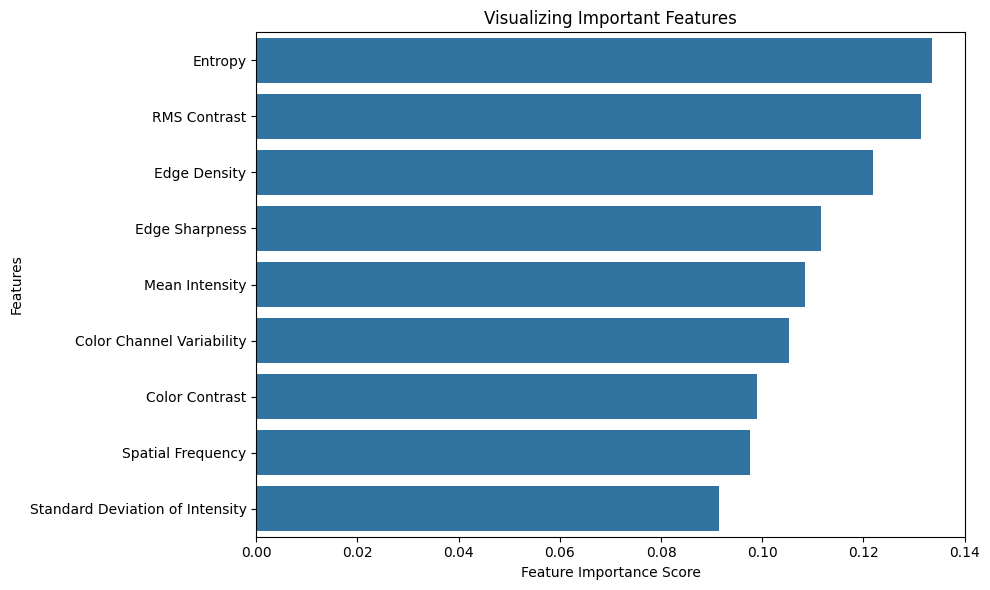

In [ ]:
# Feature Importance
rf = RandomForestClassifier(random_state=42)
multi_rf = MultiOutputClassifier(rf, n_jobs=-1)
multi_rf.fit(X, y)
feature_imp = pd.Series(multi_rf.estimators_[0].feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

Here, we want to select the optimal number of features to be selected that will construct the best random forest model.

In [ ]:
# Evaluating performance using different number of features
scores = []
times = []
for n in range(1, X.shape[1] + 1):

    # getting top n features
    top_features = feature_imp.head(n).index
    top_features_idx = [list(feature_names).index(name) for name in top_features]

    # slicing X
    X_top = X[:, top_features_idx]
    print(f"shape of X_top {X_top.shape}")

    # Evaluating performance
    start_time = time.time()

    rf = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2, n_estimators=50)
    multi_rf = MultiOutputClassifier(rf, n_jobs=-1)
    multi_rf.fit(X_top, y)
    score = multi_rf.score(X_top, y)
    elapsed_time = time.time() - start_time

    scores.append(score)
    times.append(elapsed_time)
    print(f"Score for top {n} features is: {score:.4f}, Time: {elapsed_time:.4f} seconds")

shape of X_top (200, 1)
Score for top 1 features is: 0.0550, Time: 0.6105 seconds
shape of X_top (200, 2)
Score for top 2 features is: 0.2150, Time: 0.6089 seconds
shape of X_top (200, 3)
Score for top 3 features is: 0.4550, Time: 0.5954 seconds
shape of X_top (200, 4)
Score for top 4 features is: 0.5800, Time: 0.6280 seconds
shape of X_top (200, 5)
Score for top 5 features is: 0.7100, Time: 0.5985 seconds
shape of X_top (200, 6)
Score for top 6 features is: 0.7250, Time: 0.6168 seconds
shape of X_top (200, 7)
Score for top 7 features is: 0.7100, Time: 0.6269 seconds
shape of X_top (200, 8)
Score for top 8 features is: 0.7050, Time: 0.6084 seconds
shape of X_top (200, 9)
Score for top 9 features is: 0.7600, Time: 0.6347 seconds


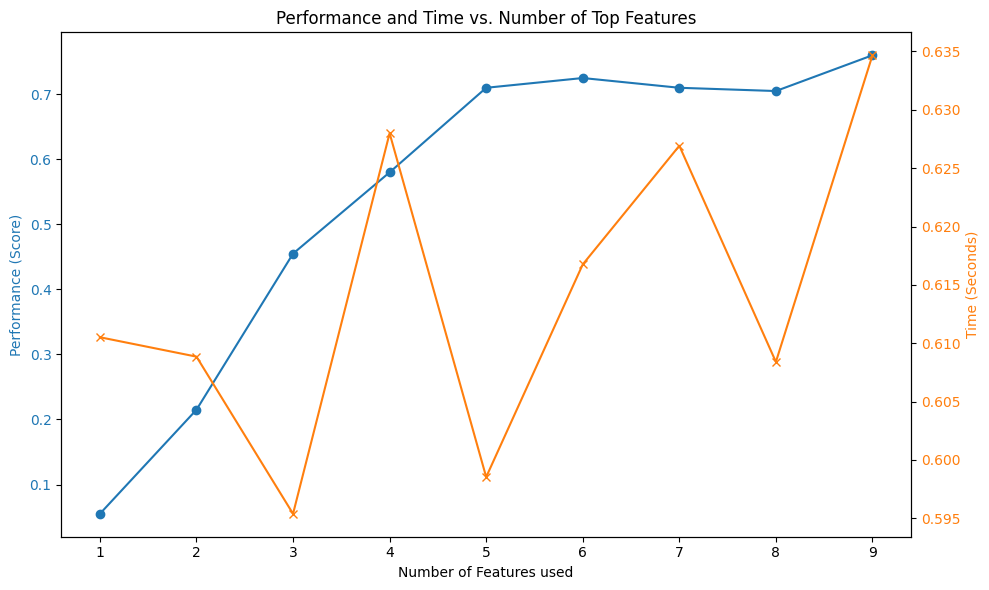

In [ ]:
# Plot performance vs. number of features
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the performance (score)
ax1.plot(range(1, X.shape[1] + 1), scores, color='tab:blue', label='Performance (Score)', marker='o')
ax1.set_xlabel('Number of Features used')
ax1.set_ylabel('Performance (Score)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot time
ax2 = ax1.twinx()
ax2.plot(range(1, X.shape[1] + 1), times, color='tab:orange', label='Time (Seconds)', marker='x')
ax2.set_ylabel('Time (Seconds)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add title and show the plot
plt.title('Performance and Time vs. Number of Top Features')
fig.tight_layout()
plt.show()

The time taken increases sharply as number of features increase above 5. However, since the time increase is minimal, we will ignore the additional time taken and take the optimal number of features as 9 (using all features).

In [ ]:
top_features_idx = list(range(9))

# 4. Parameter Prediction


We utilise random forest classifier as the model to predict the optimal set of preprocessing parameters.

Using gridsearch, we tune the hyperparameters of the random forest classifier to optimise the accuracy of the predictions. The optimal random forest classifier is then built using the best estimators.

In [ ]:
X = np.load(f'{data_dir}/saved_variables/train_features.npy')
y = np.load(f'{data_dir}/saved_variables/train_targets.npy')

In [ ]:
# Define the parameter grid
param_grid = {
    'estimator__n_estimators': [50, 100, 150],  # Number of trees
    'estimator__max_depth': [10, 20],  # Max depth of trees
    'estimator__min_samples_split': [5, 10],  # Min samples to split node
    'estimator__min_samples_leaf': [2, 5],  # Min samples per leaf
}

# Construct random forest classifier
rf = RandomForestClassifier(random_state=42)
multi_rf = MultiOutputClassifier(rf, n_jobs=-1)

# GridSearch to tune hyperparameters
grid_search = GridSearchCV(estimator=multi_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Printing optimal parameters
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Saving the best random forest model
with open(os.path.join(data_dir, 'saved_variables', 'rf.pkl'), 'wb') as f:
    pickle.dump(best_model, f)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 50}


In [ ]:
acc_rf = best_model.score(X, y)
print("Train Accuracy for RF: ", acc_rf)

Train Accuracy for RF:  0.74


# 5. Image Preprocessing + 6. Edge Detection

Using the random forest model, we predict the optimal parameters for each of the images based on the 3 selected features of the image.

Finally, we then generate edges of using the preprocessed image.

In [ ]:
with open(os.path.join(data_dir, 'saved_variables', 'rf.pkl'), 'rb') as f:
    best_model = pickle.load(f)

## Train images

In [ ]:
predictions = {}
optimal_parameters = {}
selected_sample_names = train_dataset.sample_names

for selected_sample_name in selected_sample_names:
    print(f"Processing image: {split}/{selected_sample_name}")
    image = train_dataset.read_image(selected_sample_name)
    boundaries = train_dataset.load_boundaries(selected_sample_name)

    # predict optimal parameters
    blur_amounts, sigmas, contrast_factors = predict_optimal_parameters(best_model, image, blur_encoder, sigma_encoder, contrast_encoder, top_features_idx)
    print(f"Predicted Parameters: blur_amount={blur_amounts}, sigma={sigmas}, contrast_factor={contrast_factors}")

    # save optimal parameters for exporting
    optimal_parameters[selected_sample_name] = [blur_amounts, sigmas, contrast_factors]

    # generate edges based on optimal parameters
    edges = generate_edges_rgb(image, blur_amounts, sigmas, contrast_factors)

    # save predictions
    predictions[selected_sample_name] = edges

    # display image
    fig, ax = plt.subplots(1, 5, figsize=(10, 8))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # display boundaries (ground truth)
    for i in range(len(boundaries)):
        ax[i + 1].imshow(boundaries[i], cmap='gray')
        ax[i + 1].set_title(f"Boundary {i + 1}")
        ax[i + 1].axis("off")
        edge_count = np.sum(boundaries[i] > 0)
        edge_density = edge_count / (boundaries[i].size)

    # display extracted edges
    ax[4].imshow(edges, cmap='gray')
    ax[4].set_title("Extracted Edge Strength")
    ax[4].axis("off")

    plt.tight_layout()
    plt.show()

# save the predictions
np.save(f'{data_dir}/predictions_train.npy', predictions)
np.save(f'{data_dir}/saved_variables/optimal_parameters_train.npy',optimal_parameters)

Output hidden; open in https://colab.research.google.com to view.

## Test images

In [ ]:
predictions = {}
optimal_parameters = {}
selected_sample_names = test_dataset.sample_names

for selected_sample_name in selected_sample_names:
    print(f"Processing image: {split}/{selected_sample_name}")
    image = test_dataset.read_image(selected_sample_name)
    boundaries = test_dataset.load_boundaries(selected_sample_name)

    # predict optimal parameters
    blur_amounts, sigmas, contrast_factors = predict_optimal_parameters(best_model, image, blur_encoder, sigma_encoder, contrast_encoder, top_features_idx)
    print(f"Predicted Parameters: blur_amount={blur_amounts}, sigma={sigmas}, contrast_factor={contrast_factors}")

    # save optimal parameters for exporting
    optimal_parameters[selected_sample_name] = [blur_amounts, sigmas, contrast_factors]

    # generate edges based on optimal parameters
    edges = generate_edges_rgb(image, blur_amounts, sigmas, contrast_factors)

    # save predictions
    predictions[selected_sample_name] = edges

    # display image
    fig, ax = plt.subplots(1, 2, figsize=(5, 3))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # display extracted edges
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title("Extracted Edge Strength")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# save the predictions
np.save(f'{data_dir}/predictions.npy', predictions)
np.save(f'{data_dir}/saved_variables/optimal_parameters.npy',optimal_parameters)

Output hidden; open in https://colab.research.google.com to view.